# Identifying POI from Enron's case

## Background 

In this project, we will explore factors that might help us predict "person of interest" (POI) in the Enron case. In 2002, Enron had collapsed into then-largest bankrupcy due to widespread financial fraud and "creative accounting". Tens of thousands of email records and financial data for Enron's top executives were released into the public domain as a result of the ensuing federal investigation. 

We will be working with a hand-compiled dataset from Udacity, which includes most of the financial data as-is, summary characteristics from the email records, as well as categorization of each executive as POI or not. For the purpose of this study, POI includes individuals who "were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity".    

In [73]:
# Load common modules 
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

## Dataset

The dataset contains 145 data points and 21 variables, including our response variable of interest "poi" as well as "email address", the latter of which is personally identifiable and will not be used. Of the 145 executives, 18 (or 12%) were identified as POI. 

In [74]:
# Load dataset 
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
del data_dict['TOTAL'] # Not sure why this was in the dataset, but deleting this before proceeding further
df = pd.DataFrame.from_dict(data_dict,orient='index')

# Print key statistics  
print 'Total # of variables: ' + str(df.shape[1])
print 'Total # of records: ' + str(df.shape[0])
print 'Total # of POI: ' + str(sum(df['poi']==True))

Total # of variables: 21
Total # of records: 145
Total # of POI: 18


We also note that the dataset is incomplete, with all but the response variable having missing values. In particular, "loan advances" had 142 missing values, which meant merely 3 individuals had this field populated. As such, it does not make sense to "loan_advances" in our analysis and we will drop the variable along with "email_address" from our dataset. 

In [75]:
# Get number of missing values by variable
df.replace("NaN", np.nan, inplace=True) # properly encode null values 
df.isnull().sum() 

salary                        51
to_messages                   59
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       59
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 59
other                         53
from_this_person_to_poi       59
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 34
from_poi_to_this_person       59
dtype: int64

In [76]:
# Drop email address and loan advances 
del df['email_address'] # cannot use as predictor as it identifies individual 
del df['loan_advances'] # only 3 data points has loan advances info 

## Feature exploration and engineering

In this section, we will explore the distributions of our predictor variables, identify any outlier values, as well as engineer new features where relevant. Given that we have quite a few variables to consider, we will discuss them by categories - namely email features, payments features, and stocks features. 

### Email features 

These are summary statistics about the email records compiled by Udacity: "to_messages" and "from_messages" are self-explanatory. The other three variables measure email activity in relation to the POIs identified. For instance, "from_this_person_to_poi" refers to the number of emails sent by the individual to the 18 POIs identified by Udacity.

Note that the creation of these variables meant that we are using information from the entire dataset, including the test set. As with many other students on the forum, I am concerned about the impact of "data-snooping" and "information leakage" in doing so. There are a number of methods to prevent looking ahead into the test dataset, but these tend to be more computationally involved and are not employed here. For the purpose of this exercise, we will go ahead and use these variables as provided, with the caveat that we should restrict the use case for any predictions to novel data, when "we suddenly gained a new datapoint and wanted to predict whether they were a POI or not... This individual would include features similar to the existing datapoints, including some measure of e-mail volume to and from other individuals, including (the known) POIs" as outlined in the instructor's reply on the forum.  

In addition, it seems appropriate to engineer additional features here: some individuals tend to send and receive more emails in general, so their number of emails to, received from, and shared receipt with POIs should be scaled accordingly. As such, we introduce the following new email features into our dataset: 

- from_this_person_to_poi_pct = from_this_person_to_poi / from_messages * 100
- from_poi_to_this_person_pct = from_poi_to_this_person / to_messages * 100 
- shared_receipt_with_poi_pct = shared_receipt_with_poi / to_messages * 100

In [77]:
# Engineer new email features 
df['from_this_person_to_poi_pct'] = df['from_this_person_to_poi'] / df['from_messages'] * 100
df['from_poi_to_this_person_pct'] = df['from_poi_to_this_person'] / df['to_messages'] * 100
df['shared_receipt_with_poi_pct'] = df['shared_receipt_with_poi'] / df['to_messages'] * 100

The summary statistics below as well as the histograms show the distribution of these email variables. Not surprisingly, the email count variables have a skewed distribution, but there no data points large enough that lead us to believe they might be an erroneous outlier. If anything, I am more concerned with the lower end of the count spectrum: 25% of the individuals sent only 23 emails based on the corpus information, which seemed unreasonably low unless they were all new hires, which is just as unlikely a scenario. Cross-referencing a paper released by Klimt and Yang who cleaned the original corpus, we know these numbers are reflected of their dataset, though we do not have additional information on how they were prepared. As such, we will take them as given. 

In [78]:
# Get summary statistics of email variables 
email_features = ['to_messages', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person', 
                  'shared_receipt_with_poi', 'from_this_person_to_poi_pct', 'from_poi_to_this_person_pct', 
                  'shared_receipt_with_poi_pct']
df[email_features].describe()

,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person,shared_receipt_with_poi,from_this_person_to_poi_pct,from_poi_to_this_person_pct,shared_receipt_with_poi_pct
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,2073.860465,608.790698,41.232558,64.895349,1176.465116,18.405548,3.796298,60.905811
std,2582.700981,1841.033949,100.073111,86.979244,1178.317641,21.061035,4.054439,28.730015
min,57.000000,12.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.837672
25%,541.250000,22.750000,1.000000,10.000000,249.750000,1.242096,0.919988,41.377885
50%,1211.000000,41.000000,8.000000,35.000000,740.500000,10.057359,2.584537,66.104396
75%,2634.750000,145.500000,24.750000,72.250000,1888.250000,27.203947,5.608871,84.119855
max,15149.000000,14368.000000,609.000000,528.000000,5521.000000,100.000000,21.734104,100.114548


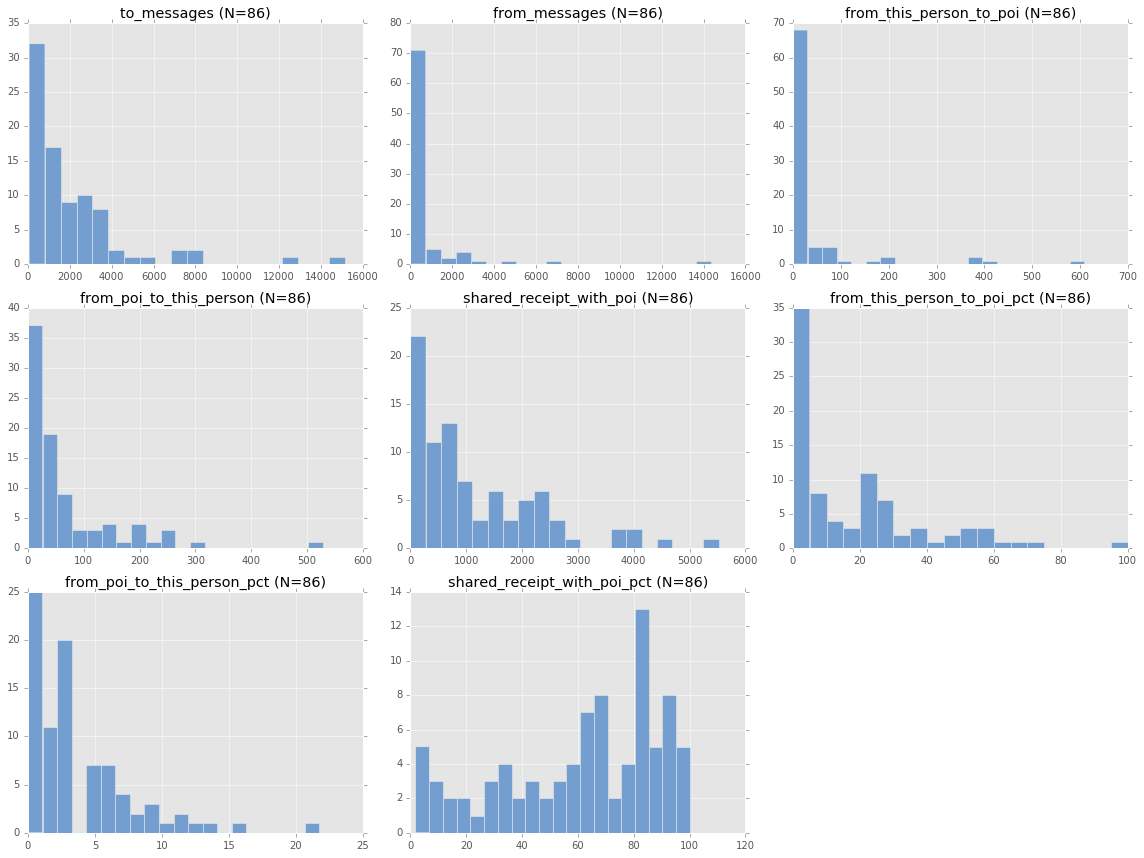

In [79]:
# Plot histograms 

%matplotlib inline
plt.figure(figsize=(16,12))

data = df[email_features]

for i, j in zip(range(len(data.columns)), data.columns):
    plot_no = 331 + i 
    plt.subplot(plot_no)
    plt.hist(data[~np.isnan(df[j])][j], bins=20, color = (0.45,0.62,0.81))
    plt.title('%s (N=%d)' % (j, data[j].count()))    

plt.tight_layout()

### Financial features - payments

Next we consider variables concerning payments to these executives. Again, we see a long tail with some very large values. However, this is not surprising as we have come to expect (though not necessary accept) that the top executives, particularly C-level executives, are typically paid significantly more than the rest of the organization. Perhaps the two areas that might raise some eyebrows are 'other' and 'total_payments', where the largest value appears to be nearly an order of magnitude larger than the bulk of the others. We will examine these data points in greater detail in the next section. 

In [80]:
# Get summary statistics of payments variables 
payments_features = ['salary', 'bonus','long_term_incentive', 'deferred_income', 'deferral_payments', 
                     'other', 'expenses', 'director_fees','total_payments']
df[payments_features].describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,total_payments
count,94.000000,81.000000,65.000000,48.000000,38.000000,92.000000,94.000000,16.000000,1.240000e+02
mean,284087.542553,1201773.074074,746491.200000,-581049.812500,841602.526316,465276.663043,54192.010638,89822.875000,2.623421e+06
std,177131.115377,1441679.438330,862917.421568,942076.402972,1289322.626180,1389719.064851,46108.377454,41112.700735,9.488106e+06
min,477.000000,70000.000000,69223.000000,-3504386.000000,-102500.000000,2.000000,148.000000,3285.000000,1.480000e+02
25%,211802.000000,425000.000000,275000.000000,-611209.250000,79644.500000,1209.000000,22479.000000,83674.500000,3.863802e+05
50%,258741.000000,750000.000000,422158.000000,-151927.000000,221063.500000,51984.500000,46547.500000,106164.500000,1.100246e+06
75%,308606.500000,1200000.000000,831809.000000,-37926.000000,867211.250000,357577.250000,78408.500000,112815.000000,2.084663e+06
max,1111258.000000,8000000.000000,5145434.000000,-833.000000,6426990.000000,10359729.000000,228763.000000,137864.000000,1.035598e+08


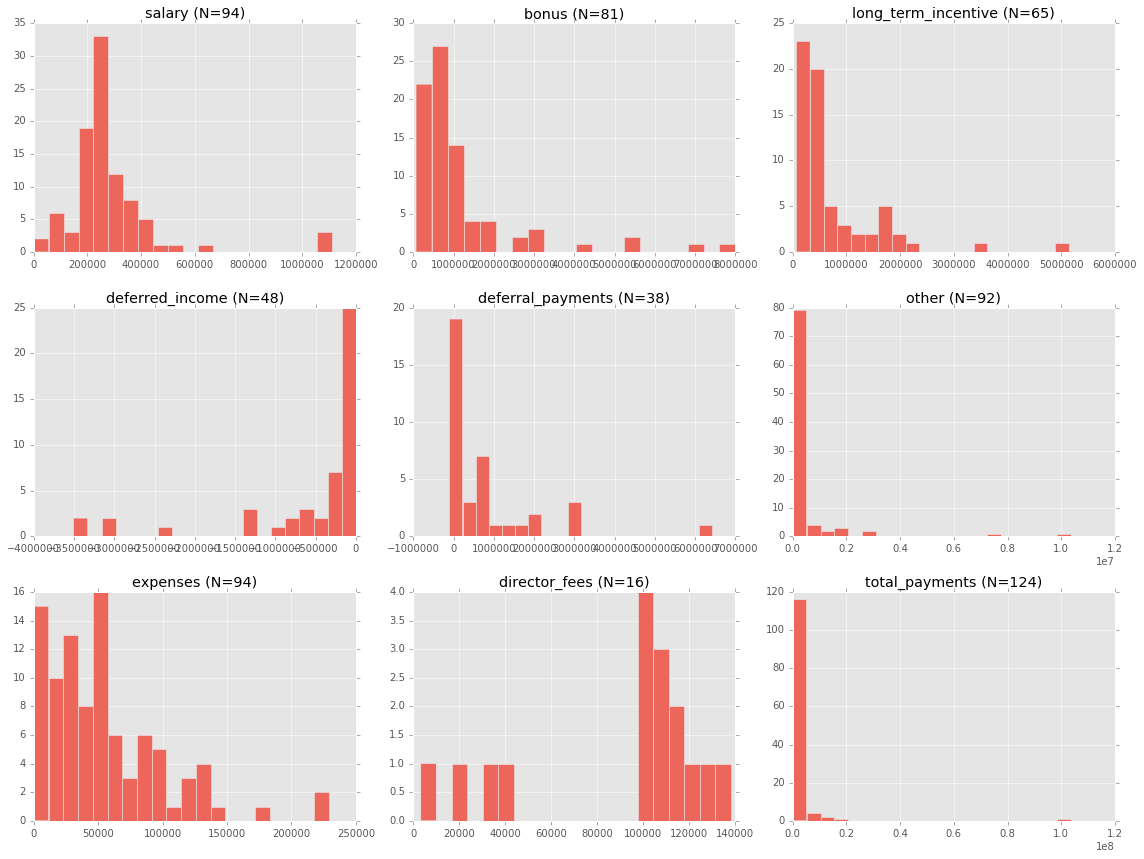

In [81]:
# Plot histograms 

plt.figure(figsize=(16,12))

data = df[payments_features]

for i, j in zip(range(len(data.columns)), data.columns):
    plot_no = 331 + i 
    plt.subplot(plot_no)
    plt.hist(data[~np.isnan(df[j])][j], bins=20, color = (0.93,0.4,0.36))
    plt.title('%s (N=%d)' % (j, data[j].count()))    

plt.tight_layout()

### Financial features - stocks

We see a similar story for the stocks features as we did for payment features. In terms of outlier values, the one variable of interest here is 'restricted_stock_deferred', where the largest value appears much farther out from every other value in the dataset. We will explore this data point further in the next section. 

In [82]:
stock_features = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
df[stock_features].describe()

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
count,101.000000,109.000000,17.000000,125.000000
mean,2959559.257426,1147424.091743,621892.823529,3352073.024000
std,5499449.598994,2249770.356903,3845528.349509,6532883.097201
min,3285.000000,-2604490.000000,-1787380.000000,-44093.000000
25%,506765.000000,252055.000000,-329825.000000,494136.000000
50%,1297049.000000,441096.000000,-140264.000000,1095040.000000
75%,2542813.000000,985032.000000,-72419.000000,2606763.000000
max,34348384.000000,14761694.000000,15456290.000000,49110078.000000


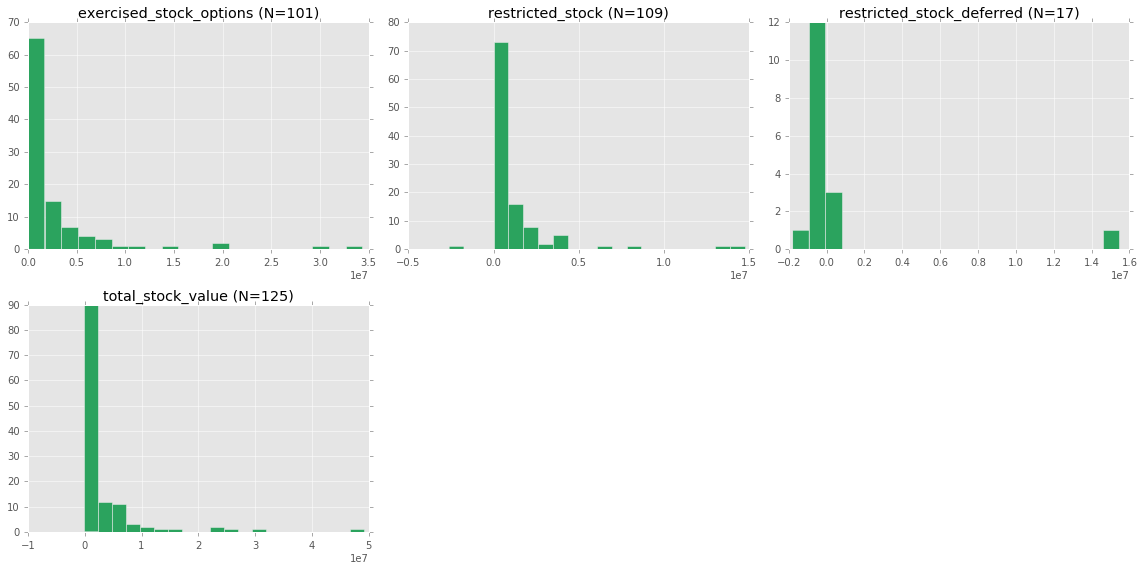

In [83]:
plt.figure(figsize=(16,8))

data = df[stock_features]

for i, j in zip(range(len(data.columns)), data.columns):
    plot_no = 231 + i 
    plt.subplot(plot_no)
    plt.hist(data[~np.isnan(df[j])][j], bins=20, color = (0.17,0.64,0.37))
    plt.title('%s (N=%d)' % (j, data[j].count()))    

plt.tight_layout()

## Preprocessing Data 

### Addressing outliers

Not surprisingly, there is a long tail of values for most of these variables, particularly with the financial variables. The two variables that are of greatest concern are 'total_payments' and 'restricted_stock_deferred', each of which had one value that was an order of magnitude greater than their respective mean. 

In [84]:
# (df['total_payments'] > 10*np.mean(df['total_payments'])) or (df['restricted_stock_deferred'] > 10*np.mean(df['restricted_stock_deferred']))
df[np.logical_or(
        df['total_payments'] > 10*np.mean(df['total_payments']),
                 df['restricted_stock_deferred'] > 10*np.mean(df['restricted_stock_deferred']))]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,from_this_person_to_poi_pct,from_poi_to_this_person_pct,shared_receipt_with_poi_pct
BHATNAGAR SANJAY,NaN,523,NaN,15456290,2604490,NaN,-2604490,463,15456290,NaN,...,137864,1,False,137864,NaN,NaN,0,3.448276,0.00000,88.527725
LAY KENNETH L,1072321,4273,202911,103559793,34348384,7000000,14761694,2411,NaN,49110078,...,10359729,16,True,NaN,-300000,3600000,123,44.444444,2.87854,56.424058


While it may not be surprising that Ken Lay, CEO and Chairman of Enron, rake in total payments that were an order of mangitude greater than the mean, it does seem odd that a relative unknown Sanjay Bhatnagar has that much higher deferred restricted stock. Cross checking with the Insider Pay PDF document, which is our effective source of truth, we confirmed that Ken's high total payments were accurate, but Sanjay's deferred restricted stock was a data entry error. In fact, it appears that all of Sanjay's financial data were input wrongly. Below, we correct these values based on the data from the PDF document. 

In [85]:
df.set_value('BHATNAGAR SANJAY', 'deferral_payments', 0)
df.set_value('BHATNAGAR SANJAY', 'total_payments', 137864)
df.set_value('BHATNAGAR SANJAY', 'exercised_stock_options', 15456290)
df.set_value('BHATNAGAR SANJAY', 'restricted_stock', 2604490)
df.set_value('BHATNAGAR SANJAY', 'restricted_stock_deferred', -2604490)
df.set_value('BHATNAGAR SANJAY', 'total_stock_value', 15456290)
df.set_value('BHATNAGAR SANJAY', 'expenses', 137864)
df.set_value('BHATNAGAR SANJAY', 'other', 0)
df.set_value('BHATNAGAR SANJAY', 'director_fees', 0)
df.loc['BHATNAGAR SANJAY']

salary                                 NaN
to_messages                            523
deferral_payments                        0
total_payments                      137864
exercised_stock_options        1.54563e+07
bonus                                  NaN
restricted_stock               2.60449e+06
shared_receipt_with_poi                463
restricted_stock_deferred     -2.60449e+06
total_stock_value              1.54563e+07
expenses                            137864
from_messages                           29
other                                    0
from_this_person_to_poi                  1
poi                                  False
director_fees                            0
deferred_income                        NaN
long_term_incentive                    NaN
from_poi_to_this_person                  0
from_this_person_to_poi_pct        3.44828
from_poi_to_this_person_pct              0
shared_receipt_with_poi_pct        88.5277
Name: BHATNAGAR SANJAY, dtype: object

### Imputing missing values 

There are two types of missing values in our dataset:  

As observed earlier, we only had email information for 86 of the 145 personnel. This leaves 59 records with no email information. Since many of machine learning methods we will be employing later cannot deal with missing values, we will impute the missing values of email variables with their respective medians. 

The other type of missing values are in the financial variables, information transcribed from the insider pay PDF. On a cursory glance, one might think that missing values simply imply zero in these cases. After all, one would not expect everyone to have received 'loan advances', or 'director fees' for instance. While this seems reasonable for most of the financial variables, the fact that we have missing 'salary' information for some causes pause. Obviously, everyone should have a salary, and particularly for this group of people, 'bonus' as well. I am inclined to drop these records, but since they make up more than one-third of our records, I decided against it. Instead, I backfilled missing salary and bonus information with their respective medians (as with the email variables), and filled the remaining missing financial information with zeros. 

In [86]:
# Impute missing email information using medians 
features_imputed = ['to_messages', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person', 
                    'shared_receipt_with_poi', 'from_this_person_to_poi_pct', 'from_poi_to_this_person_pct',
                    'shared_receipt_with_poi_pct', 'salary', 'bonus']
for variable in features_imputed: 
    df[variable] = np.where(np.isnan(df[variable]), 
                            np.median(df[~np.isnan(df[variable])][variable]), df[variable])
    
# Replace all NaN's in non-Salary/Bonus financial variables 
features_zeroed = ['long_term_incentive', 'deferred_income', 'deferral_payments', 'other', 
                   'expenses', 'director_fees','total_payments', 'exercised_stock_options', 
                   'restricted_stock', 'restricted_stock_deferred', 'total_stock_value'] 
for variable in features_zeroed: 
    df[variable] = np.where(np.isnan(df[variable]),0,df[variable])

In [267]:
# Prepare data in format that tester.py requires 
my_dataset = df.to_dict(orient='index')
features_list = ['poi','salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 
                 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred',
                 'total_stock_value', 'expenses', 'from_messages', 'other', 'from_this_person_to_poi',
                 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person',
                 'from_this_person_to_poi_pct', 'from_poi_to_this_person_pct', 'shared_receipt_with_poi_pct']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Fitting Model 

As a start, we fit 4 popular classification algorithms to see how each of them perform out-of-the-box on our dataset, with full features used. Note that since we have a sample size with highly imbalanced class, we will perform cross-validation with a stratified shuffled split when fitting and evaluating our models. 

Note that in creating our classifiers, we used make_pipeline which included a Min-Max scaling of our features. This is importance as email and financial variables are on very different scales, while scale affects results in several of the machine learning algorithms we are employing. 

In [240]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Build function that returns evaluation metrics for a classifier based on a stratified shuffled split
def test_classifier(clf, folds = 1000):
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        # fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break

    # Compute evaluation metrics, store and return as dictionary 
    metrics = {} 
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    metrics['accuracy'] = 1.0*(true_positives + true_negatives)/total_predictions
    metrics['precision'] = 1.0*true_positives/(true_positives+false_positives)
    metrics['recall'] = 1.0*true_positives/(true_positives+false_negatives)
    metrics['f1'] = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
    metrics['f2'] = (1+2.0*2.0) * metrics['precision']*metrics['recall'] /(4*metrics['precision'] + metrics['recall'] )
    return metrics

# Fit the 4 classifiers and return results in a dictionary, read as a dataframe
model_metrics = {} 
model_metrics['kNN'] = test_classifier(make_pipeline(MinMaxScaler(), KNeighborsClassifier()), folds = 1000)
model_metrics['decision_tree'] = test_classifier(make_pipeline(MinMaxScaler(), DecisionTreeClassifier()), folds = 1000)
model_metrics['random_forest'] = test_classifier(make_pipeline(MinMaxScaler(), RandomForestClassifier()), folds = 1000)
model_metrics['logit'] = test_classifier(make_pipeline(MinMaxScaler(), LogisticRegression()), folds = 1000)
pd.DataFrame(model_metrics)

,decision_tree,kNN,logit,random_forest
accuracy,0.805733,0.868400,0.873067,0.862800
f1,0.258901,0.198864,0.236568,0.212701
f2,0.256242,0.144731,0.173652,0.161365
precision,0.263458,0.528017,0.597166,0.452769
recall,0.254500,0.122500,0.147500,0.139000


Based on the results above, logit and decision tree perform best out of the box, with higher F1 scores than kNN and random forest. These two methods complement one another - while logit does a good job at capturing linear effects (and its lasso form assists with feature selection), decision trees capture interaction effects that may exist between variables that logit will not (without additional model specifications). Both of them also provide coefficients or variable importances that provide an indication of the relative importance of each feature considered. As next steps, we will attempt to fit better versions of these two models by carefully tunning parameters and applying variable selection, and use the more performant model of the two as our final model. 

### Logistic regression (with feature selection via lasso)

In [268]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path

alphas = np.logspace(-6, 1, 50)

lasso = make_pipeline(MinMaxScaler(), 
                      LassoCV(random_state = 42, cv=50, copy_X = True, alphas = alphas)).fit(features, labels)
sfm = SelectFromModel(lasso.steps[1][1], prefit=True)
features_lasso = sfm.transform(features)
n_features_lasso = features_lasso.shape[1]
alpha_lasso = -np.log10(lasso.steps[1][1].alpha_)

(-1.0, 6.0, -0.0021597044991178401, 0.0056293558631358492)

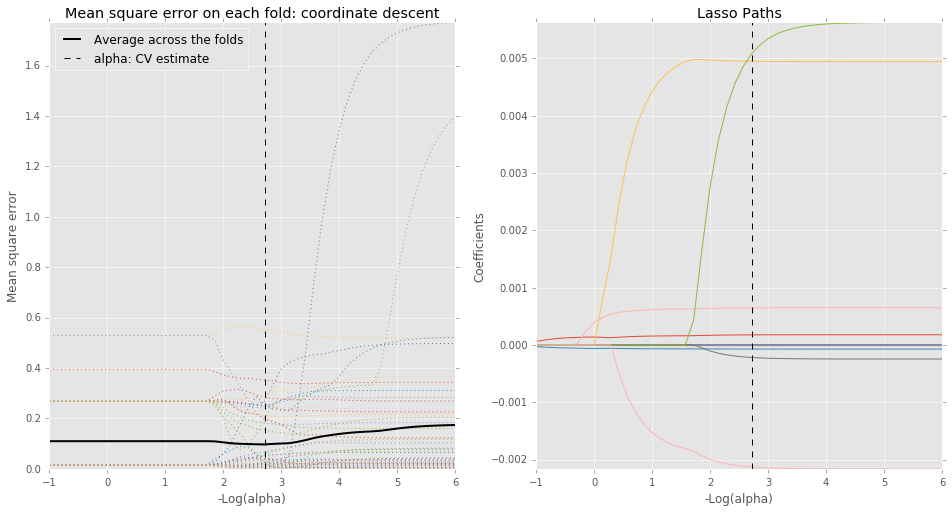

In [269]:
plt.figure(figsize=(16,8))

# Plot MSE by alpha 
plt.subplot(121)
m_log_alphas = -np.log10(lasso.steps[1][1].alphas_)
plt.plot(m_log_alphas, lasso.steps[1][1].mse_path_, ':')
plt.plot(m_log_alphas, lasso.steps[1][1].mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso.steps[1][1].alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend(loc = 'upper left')
plt.xlabel('-Log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent')
plt.axis('tight')

# Plot lasso paths 
plt.subplot(122)
alphas_lasso, coefs_lasso, _ = lasso_path(features, labels, alphas = alphas)
plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
plt.axvline(-np.log10(lasso.steps[1][1].alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.axis('tight')

In [270]:
print "Lasso CV selected an alpha of %.2f with %d features:" % (alpha_lasso, n_features_lasso)
lasso_coef = pd.DataFrame({'coef': lasso.steps[1][1].coef_.tolist()}, features_list[1:]).round(3)
lasso_coef[lasso_coef['coef']!=0].sort('coef', ascending=False)

Lasso CV selected an alpha of 2.71 with 11 features:


,coef
exercised_stock_options,0.549
from_this_person_to_poi_pct,0.447
restricted_stock_deferred,0.244
expenses,0.153
bonus,0.121
shared_receipt_with_poi,0.108
salary,0.036
from_this_person_to_poi,0.033
director_fees,-0.031
deferred_income,-0.420


In [266]:
features_list = ['poi'] + lasso_coef[lasso_coef['coef']!=0].index.tolist()
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
test_classifier(make_pipeline(MinMaxScaler(), DecisionTreeClassifier()), folds = 1000)

{'accuracy': 0.8217333333333333,
 'f1': 0.28882978723404257,
 'f2': 0.27817622950819676,
 'precision': 0.3085227272727273,
 'recall': 0.2715}

### Decision Tree

In [305]:
from sklearn.grid_search import GridSearchCV
params = {
    'decisiontreeclassifier__max_features': ['auto', 'sqrt', 'log2', None],   
    'decisiontreeclassifier__max_depth': [1, 3, 5, 9]
}

pipe = make_pipeline(MinMaxScaler(),DecisionTreeClassifier())
clf = GridSearchCV(estimator = pipe, param_grid = params, scoring = 'f1')
clf.fit(features, labels)
clf.best_params_ 
clf.grid_scores_

[mean: 0.19310, std: 0.14164, params: {'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__max_features': 'auto'},
 mean: 0.00000, std: 0.00000, params: {'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__max_features': 'sqrt'},
 mean: 0.11034, std: 0.15713, params: {'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__max_features': 'log2'},
 mean: 0.19310, std: 0.14164, params: {'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__max_features': None},
 mean: 0.26470, std: 0.02993, params: {'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': 'auto'},
 mean: 0.24075, std: 0.17142, params: {'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': 'sqrt'},
 mean: 0.14551, std: 0.11676, params: {'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': 'log2'},
 mean: 0.18506, std: 0.02619, params: {'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__ma

## To delete: 

In [296]:
from sklearn.decomposition import PCA
payments_features = ['salary', 'bonus','long_term_incentive', 'deferred_income', 'deferral_payments', 
                     'other', 'expenses', 'director_fees','total_payments', 'exercised_stock_options', 
                     'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
X_fin = X[payments_features]
pca_fin_full = PCA(n_components=13)
pca_fin_full.fit(X_fin)

# Print the components and the amount of variance in the data contained in each dimension
print "The PCA components are:"
print pd.DataFrame(pca_fin_full.components_, columns=X_fin.columns, index=range(1,14)) 
print ""
print "The explained variance ratios are:"
print pca_fin_full.explained_variance_ratio_


The PCA components are:
      salary     bonus  long_term_incentive  deferred_income  \
1   0.331125  0.290165             0.281711        -0.168441   
2   0.080609  0.090566             0.121068        -0.575541   
3   0.098706  0.147738             0.174550         0.291713   
4   0.034337 -0.113410            -0.245062        -0.091332   
5   0.196678  0.250121             0.065760        -0.049559   
6  -0.022245 -0.457261            -0.493120         0.165209   
7  -0.069347  0.317556            -0.383569        -0.279765   
8  -0.327846 -0.538923             0.479133        -0.343996   
9   0.808505 -0.351690             0.089436        -0.013200   
10 -0.158671  0.086243            -0.037248        -0.364373   
11  0.203724 -0.105083            -0.420985        -0.425617   
12 -0.033258  0.260423            -0.068243         0.080619   
13 -0.000045 -0.000012             0.000063         0.000012   

    deferral_payments     other  expenses  director_fees  total_payments  \
1  

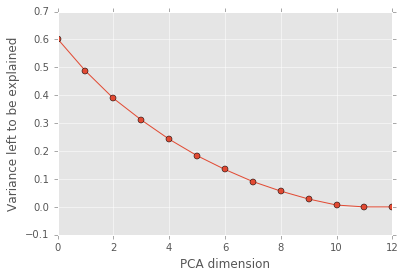

In [297]:
plt.plot(np.arange(13), 1 - np.cumsum(pca_fin_full.explained_variance_ratio_), '-o')
plt.xlabel("PCA dimension")
plt.ylabel("Variance left to be explained")

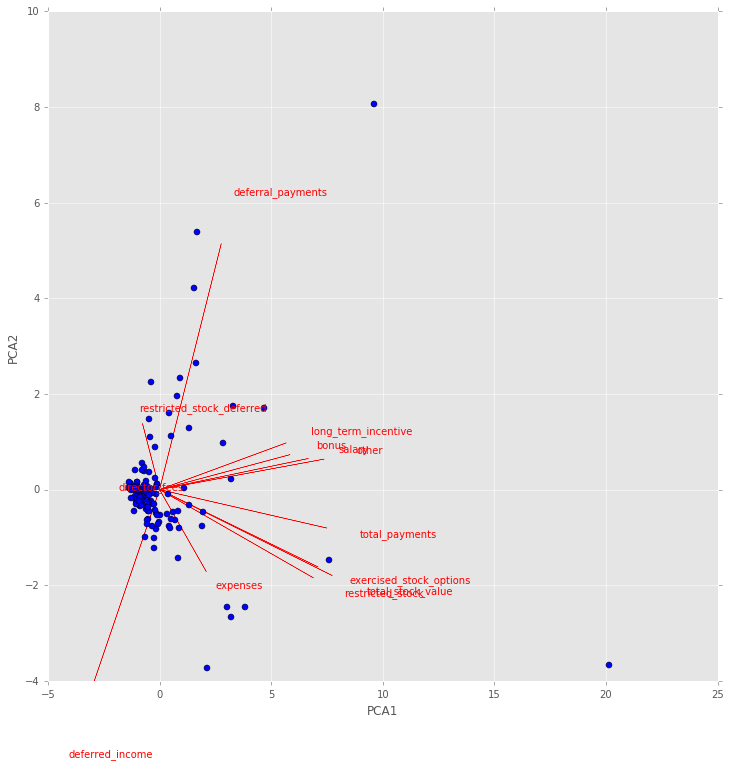

In [298]:
pca = PCA(n_components = 2)
pca.fit(X_fin)
xvector = pca.components_[0] 
yvector = pca.components_[1]

xs = pca.transform(X_fin)[:,0] 
ys = pca.transform(X_fin)[:,1]

plt.figure(figsize=(12,12))
plt.xlabel('PCA1')
plt.ylabel('PCA2')

for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(X_scaled_fin.columns.values)[i], color='r', size=10)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')

Populating the interactive namespace from numpy and matplotlib


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cab7dd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10edcf590>]], dtype=object)

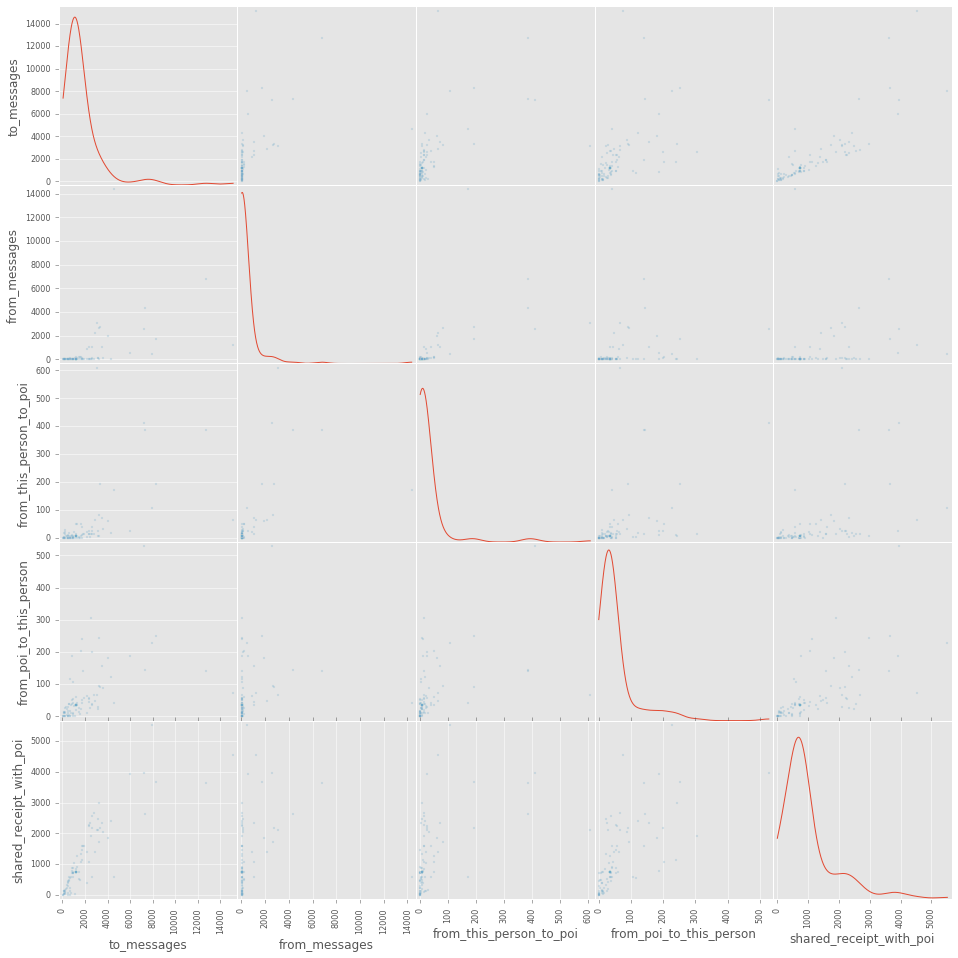

In [262]:
### Scatterplot matrix for email features

% pylab inline 

from pandas.tools.plotting import scatter_matrix
scatter_matrix(df[email_features], alpha=0.2, figsize=(16, 16), diagonal='kde')

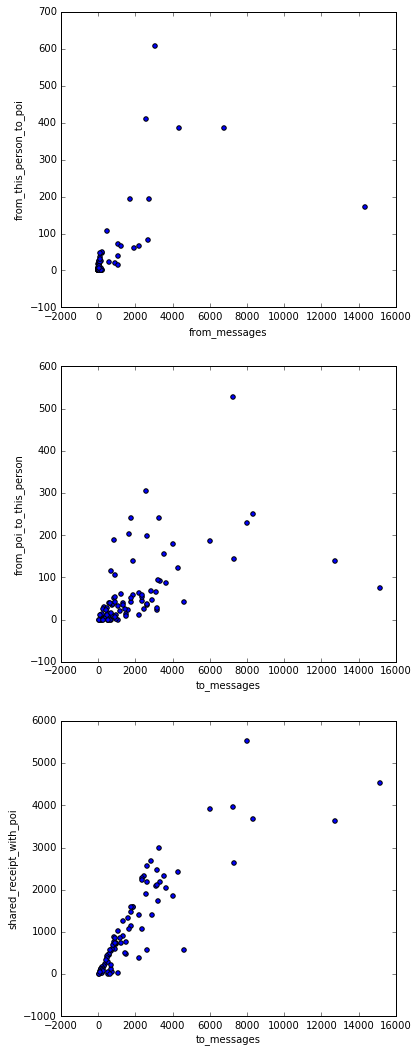

In [27]:
### Analyze specific email scatterplots of interest

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figheight(18)
fig.set_figwidth(6)

df_to_poi = df[['from_this_person_to_poi','from_messages','poi']].dropna()
df_to_poi.plot(kind='scatter',x='from_messages',y='from_this_person_to_poi',ax=axes[0])

df_from_poi = df[['from_poi_to_this_person','to_messages']].dropna()
df_from_poi.plot(kind='scatter',x='to_messages',y='from_poi_to_this_person',ax=axes[1])

df_shared = df[['shared_receipt_with_poi','to_messages']].dropna()
df_shared.plot(kind='scatter',x='to_messages',y='shared_receipt_with_poi',ax=axes[2])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c80a210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e361f50>]], dtype=object)

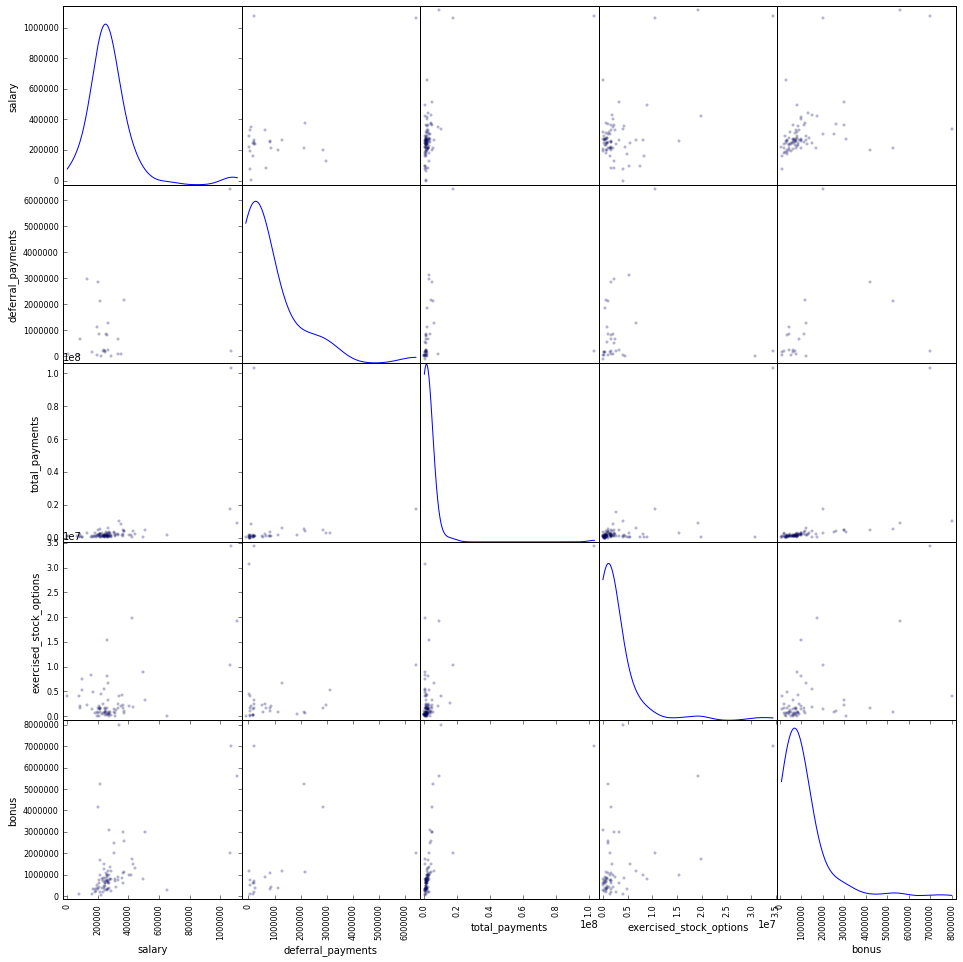

In [28]:
### Scatterplot matrix for financial features (1) 

scatter_matrix(df[financial_features1], alpha=0.2, figsize=(16, 16), diagonal='kde')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f460a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1227715d0>]], dtype=object)

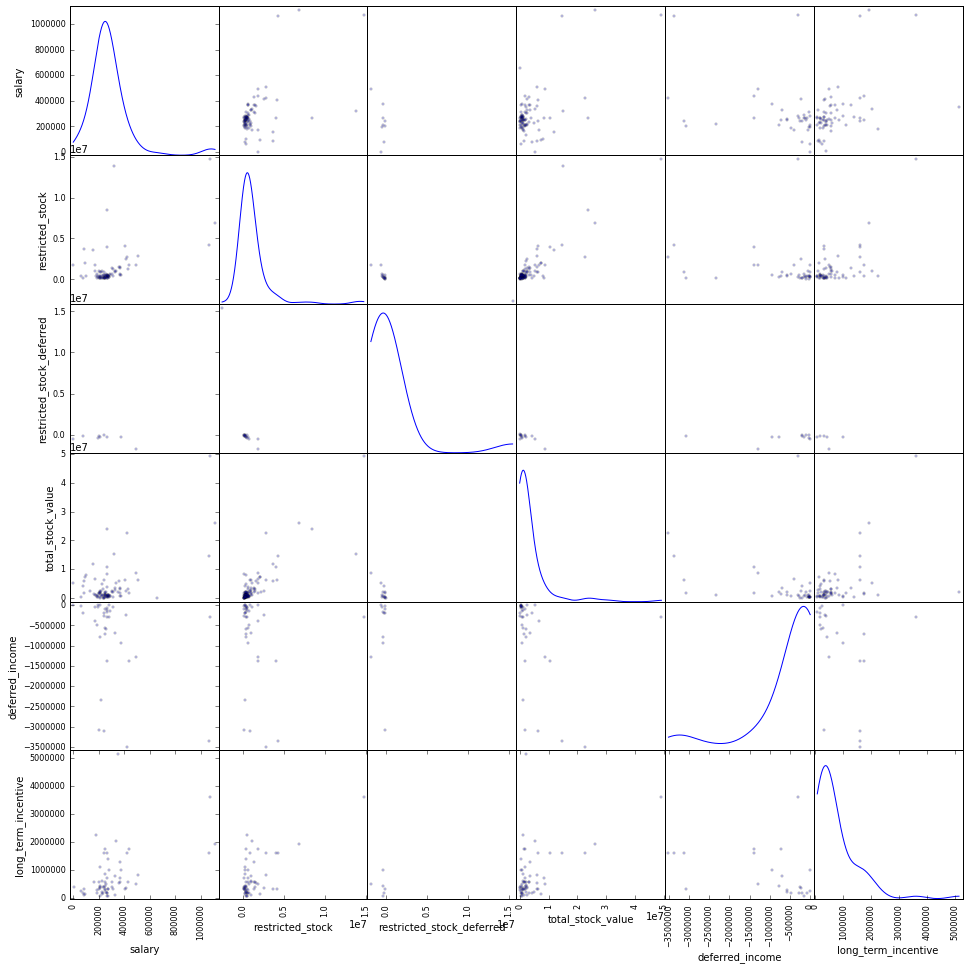

In [29]:
### Scatterplot matrix for financial features (2) 

scatter_matrix(df[financial_features2], alpha=0.2, figsize=(16, 16), diagonal='kde')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123128850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124edf210>]], dtype=object)

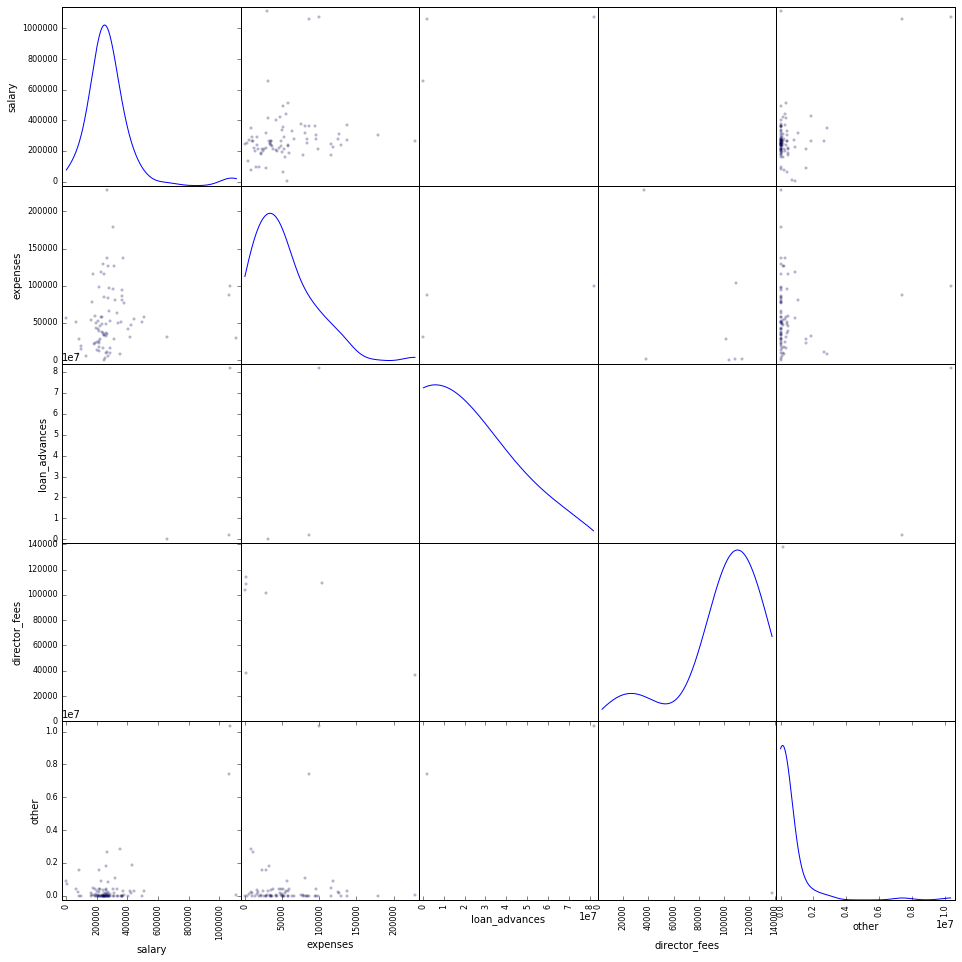

In [30]:
### Scatterplot matrix for financial features (3) 

scatter_matrix(df[financial_features3], alpha=0.2, figsize=(16, 16), diagonal='kde')

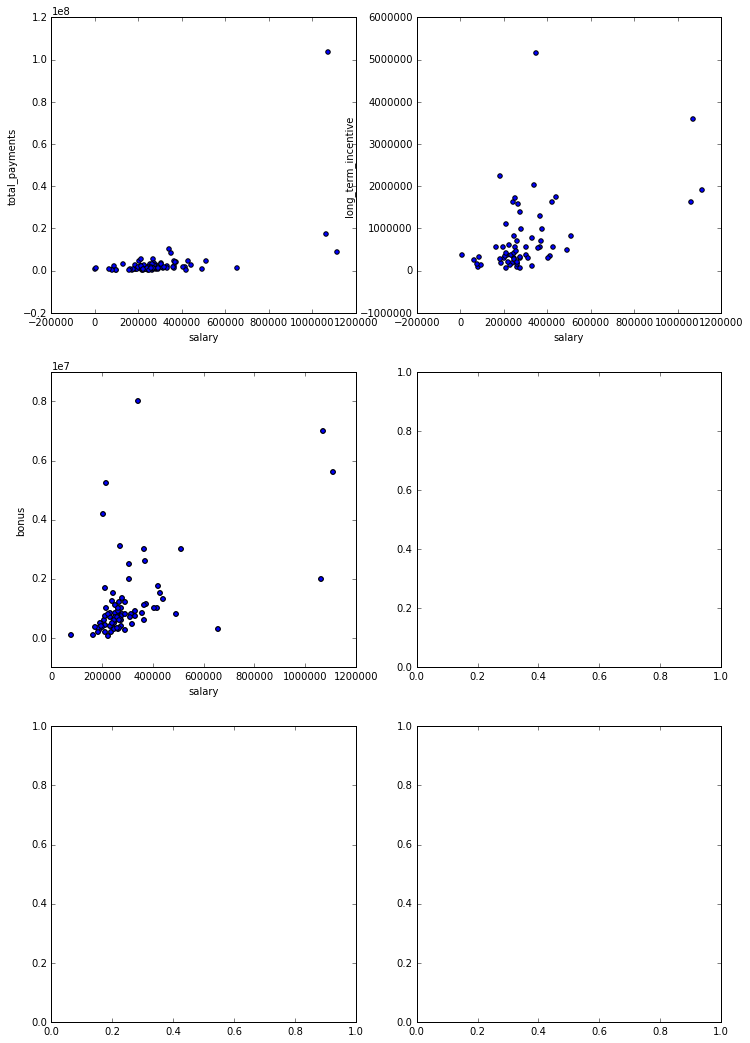

In [31]:
### Analyze specific financial scatterplots of interest

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(18)
fig.set_figwidth(12)

df_salary_total_payments = df[['salary','total_payments']].dropna()
df_salary_total_payments.plot(kind='scatter',x='salary',y='total_payments',ax=axes[0,0])

df_salary_LT_incentive = df[['salary','long_term_incentive']].dropna()
df_salary_LT_incentive.plot(kind='scatter',x='salary',y='long_term_incentive',ax=axes[0,1])

df_salary_bonus = df[['salary','bonus']].dropna()
df_salary_bonus.plot(kind='scatter',x='salary',y='bonus',ax=axes[1,0])

df_salary_bonus = df[['salary','bonus']].dropna()
df_salary_bonus.plot(kind='scatter',x='salary',y='bonus',ax=axes[1,0])

# References

- http://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
- http://ceas.cc/2004/168.pdf
- http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#example-linear-model-plot-lasso-coordinate-descent-path-py